In [ ]:
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import math
import torch
import torchvision.transforms as transforms
from collections import deque
import random
import torch.nn as nn
import torch.nn.functional as F
from itertools import count
import torch.optim as optim

torch.set_default_tensor_type(torch.FloatTensor)

env = gym.make("Humanoid-v4", render_mode="human")
obs,info = env.reset()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def plot_rewards(rewards, mode = "Training"):
  # Reward Dynamics
  plt.figure(figsize=(15, 10))
  plt.plot(rewards)
  plt.xlabel('Episode', fontsize=28)
  plt.ylabel('Reward Value', fontsize=28)
  plt.title(mode, fontsize=36)
  plt.xticks(fontsize=24)
  plt.yticks( fontsize=24)
  plt.grid()
  plt.show()

In [ ]:
# Neural network that takes in a state and produces Q values for all actions
class Net(nn.Module):
    def __init__(self, obs_size, no_actions):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(obs_size, 648)
        self.fc2 = nn.Linear(648, 648)
        self.fc3 = nn.Linear(648, no_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, obs, Q, epsilon = 1):
    # Choose action A from from state S using policy derived from Q
    rand = np.random.random()
    if rand < epsilon:
      action = env.action_space.sample()
      return torch.tensor(action, device = device)
      #Else Best action - look at Q table and see which action has the best Q value for current state (or observation)
    else:
      action = []
      out = Q(obs.type(torch.float32))
      action = torch.tensor(out, device=device, dtype=torch.float32)
      return action

agent = RandomAgent(env)
dtype=torch.float32


reward after episode 0: 93.64228068538415 
reward after episode 1: 83.38927996678254 


C:\Users\Manudeep\AppData\Local\Temp\ipykernel_18348\881278347.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action = torch.tensor(out, device=device, dtype=torch.float32)


reward after episode 2: 132.07668371052526 
reward after episode 3: 134.04429169704795 
reward after episode 4: 94.44107584397727 
reward after episode 5: 101.23443784733877 
reward after episode 6: 135.9772617944737 
reward after episode 7: 116.22404982552379 
reward after episode 8: 78.24087110005382 
reward after episode 9: 116.4726796873478 
reward after episode 10: 180.23393958102582 
reward after episode 11: 84.30249737462016 
reward after episode 12: 144.5360281517728 
reward after episode 13: 86.45028473740071 
reward after episode 14: 144.83359819006964 
reward after episode 15: 253.4605015183662 
reward after episode 16: 113.84394617802604 
reward after episode 17: 85.7257742458775 
reward after episode 18: 85.69883655151526 
reward after episode 19: 100.7941570025571 
reward after episode 20: 164.09901644516685 
reward after episode 21: 92.68333233278464 
reward after episode 22: 74.81360159150238 
reward after episode 23: 126.80762293975917 
reward after episode 24: 145.301

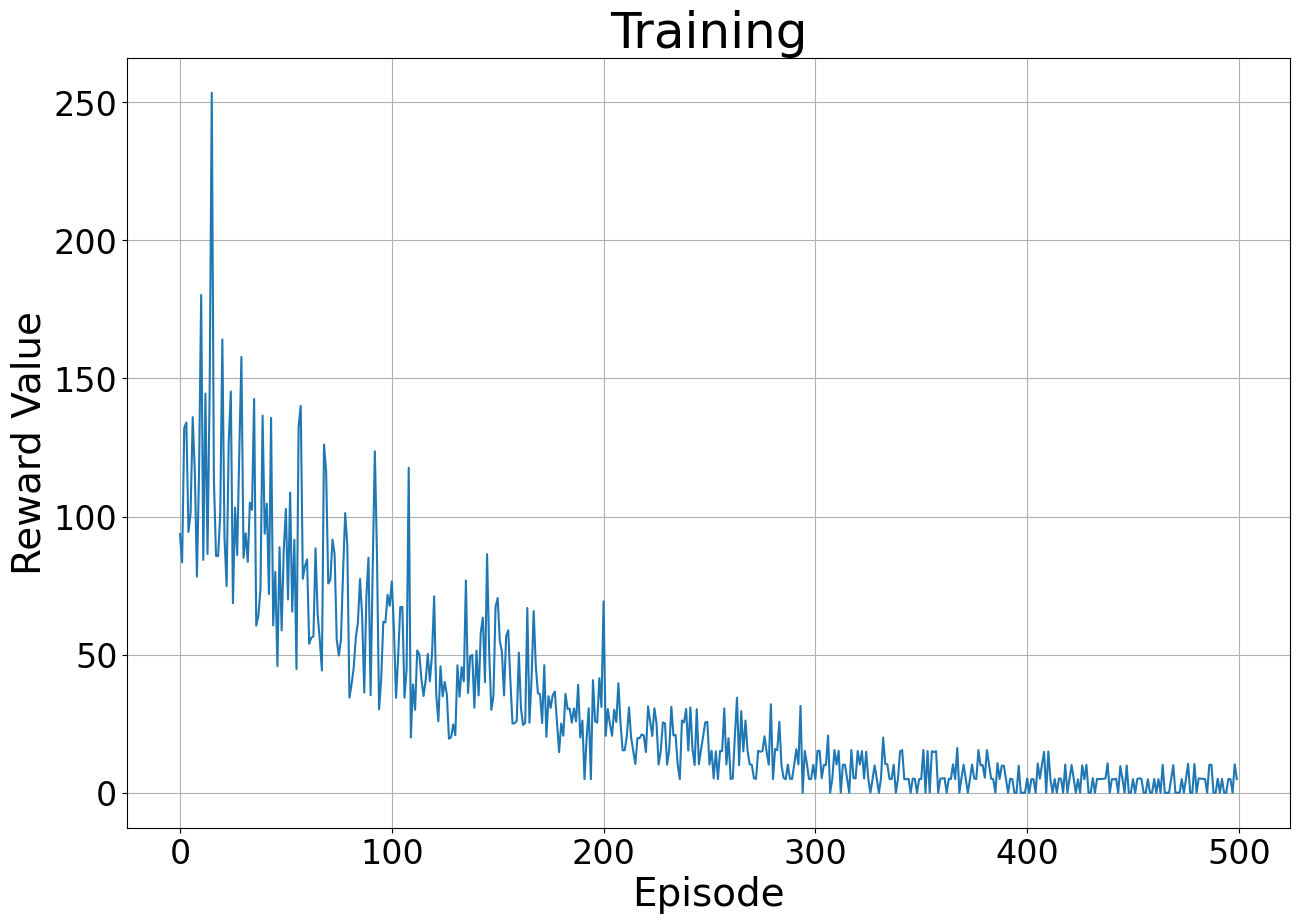

In [ ]:
# Inititalization and parameters
gamma = 0.75 # discount factor
no_episodes = 500

# initial epsilon value
epsilon = 1
decay_rate = (0.01 / 1)**(1/no_episodes) # epsilon decay rate

# results stored here
reward_per_episode_train = []
epsilon_values = []

# 1. Initialize replay memory
minibatch_size = 64
D = deque(maxlen=10000)

# Init Q net and target Q net
Q = Net(376, 17).to(device)
Q_target = Net(376, 17).to(device)
# Copy weights from Q to Q_target
Q_target.load_state_dict(Q.state_dict())

# Loss function setup
criterion = nn.MSELoss() # MSE loss
optimizer = optim.SGD(Q.parameters(), lr=0.005, momentum=0.70) # stochastic gradient descent to calculate updated weights

# 4. Loop for multiple episodes.
for e in range(no_episodes):
  # 5. Initialize the state.
  new_state, _ = env.reset()
  episode_reward, terminated, truncated, epsilon = 0, False, False,  epsilon * decay_rate
  epsilon_values.append(epsilon)

  # 6. Until the episode ends
  ts = 0
  while not terminated and not truncated:
    ts += 1
    # new_state from the previous iteration is the current state now.
    curr_state = torch.tensor(new_state, device=device)

    # 7. Pick an action with probability epsilon
    action = agent.step(curr_state, Q, epsilon)

    # 8. Take action A
    new_state, reward, terminated, truncated, _ = env.step(action)
    next_state = torch.tensor(new_state, device=device)


    if not math.isnan(reward):
       episode_reward += reward
      #  print("NAN", reward, episode_reward)

    # 9. Store st, at, rt, st+1, terminated in D
    D.append([curr_state, action, reward ,next_state, terminated])

    # 10. Sample random minibatch from D (s, a, r, sp, terminated)
    if len(D) < minibatch_size:
      continue # if not enough records in replay memory, continue to next iteration

    minibatch = random.sample(D, minibatch_size)

    # For transitions in minibatch calculate error and backprop.
    loss = None
    curr_states = []
    actions = []
    targets = []
    for st, at, rt, st1, ter  in minibatch:
      yj = None
      if ter:
        continue
        # yj = torch.tensor(rt, dtype=torch.float32, device=device)
      else:
        yj = rt + gamma * Q_target(st1.type(torch.float32))# Take the max of Qc(obs)
        # yj = rt + gamma * Q_target(st1.type(torch.float32))[torch.argmax(Q(st1.type(torch.float32)))] # Take Q target(next_state or st1) for best action in Q
      curr_states.append(st)
      actions.append(at)
      targets.append(yj)

    if len(curr_states) == 0:
       continue
    curr_states = torch.stack(curr_states)
    # Q values for the selected actions for the list of curr_states
    prediction = Q(curr_states.type(torch.float32))
    # Q values for best actions from next_state
    target = torch.stack(targets).to(device)

    # Reset the leftover gradient
    optimizer.zero_grad()
    # Calculate loss
    loss = criterion(prediction, target)
    # Calculate the delta IG
    loss.backward()
    # Pass the loss to all the nodes
    optimizer.step()

    Q_target_state_dict = Q_target.state_dict()
    Q_state_dict = Q.state_dict()

    # Every step soft update the weights
    if ts:
      # update the target network weights
      for key in Q_state_dict:
            Q_target_state_dict[key] = Q_state_dict[key]*0.05 + Q_target_state_dict[key]*(1-0.05)
            Q_target.load_state_dict(Q_target_state_dict)

  reward_per_episode_train.append(episode_reward)
  print("reward after episode {0}: {1} ".format(e, episode_reward) )
print("last 10 rewards: \n", reward_per_episode_train[-10:], terminated)

plot_rewards(reward_per_episode_train)

In [ ]:
# Learning parameters
no_episodes = 10
reward_per_episode_test = []

# 4. Loop for multiple episodes.
for episode in range(no_episodes):
  # 5. Initialize the state.
  obs, _ = env.reset()
  episode_reward, terminated, truncated,  = 0, False, False

  ts = 0
  while not terminated:
    ts += 1
    curr_state = torch.tensor(obs, device=device)
    # 7. Pick an action with probability epsilon
    action = agent.step(curr_state, Q, 0)
    # 8. Take action A
    obs, reward, terminated, truncated, _ = env.step(action.item())
    episode_reward += reward

  reward_per_episode_test.append(episode_reward)
  print("reward after episode {0}: {1} ".format(episode, episode_reward) )
print("TOTAL REWARD: \n", reward_per_episode_test[-10:], terminated)
plot_rewards(reward_per_episode_test, "Testing")



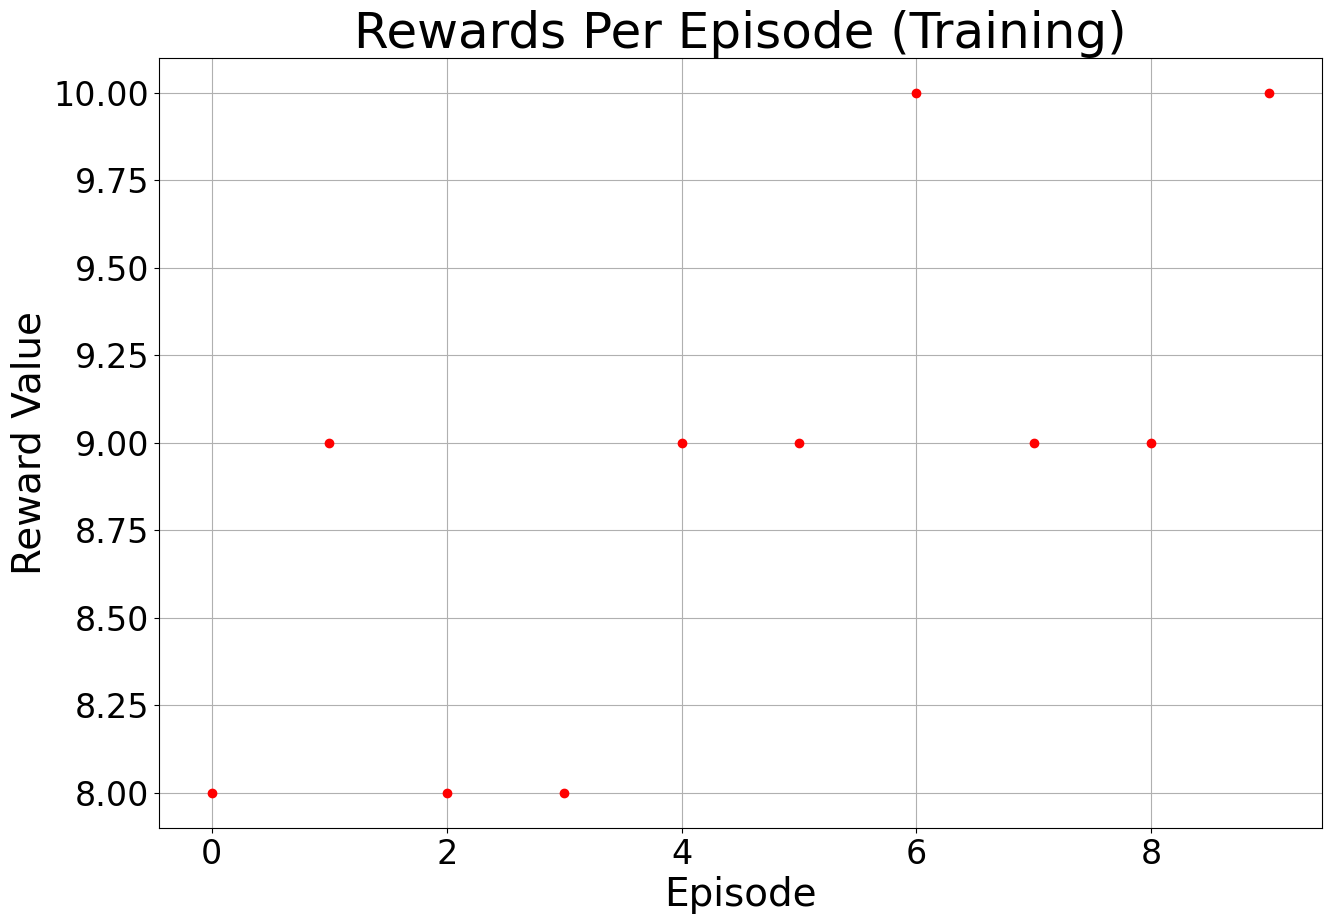

In [ ]:
# Epsilon-decay
plt.figure(figsize=(10, 8))
plt.plot(epsilon_values, linewidth=4)
plt.xlabel('Episode no.', fontsize=24)
plt.ylabel('Epsilon Values', fontsize=24)
plt.title('Epsilon Decay', fontsize=32)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.ylim(ymin=0, ymax=1)
plt.xlim(xmin=0, xmax=no_episodes)
plt.grid()
plt.show()